# 3MD3220: Reinforcement Learning - Individual Assignment

**Author:** Alexandre Boistard 
**Date:** March 2025

---

## Introduction

This notebook presents the implementation and comparison of two 
reinforcement learning agents— a Monte Carlo-based agent and a Sarsa 
agent—applied to the Text Flappy Bird (TFB) environment. 

In this notebook, two RL approaches are implemented:
1. A **Monte Carlo-based agent** that learns by averaging returns over 
complete episodes.
2. A **Sarsa agent** that utilizes eligibility traces to incrementally 
update its policy based on temporal-difference error.

The notebook is structured as follows:
- **Preliminaries:** Importing libraries, environment setup, and state 
discretization functions.
- **Agent Implementations:** Detailed code for both the Monte Carlo and 
Sarsa(λ) agents.
- **Training and Evaluation:** Training loops, performance tracking, and 
parameter sweeps.
- **Results and Analysis:** Visualization of rewards, state-value functions,
 and discussion of findings.

This structured approach allows us to compare the convergence properties, 
stability, and adaptability of both agents under different environmental 
configurations.

Environment configuration: {'height': 15, 'width': 20, 'pipe_gap': 4}
Random seeds set for reproducibility.


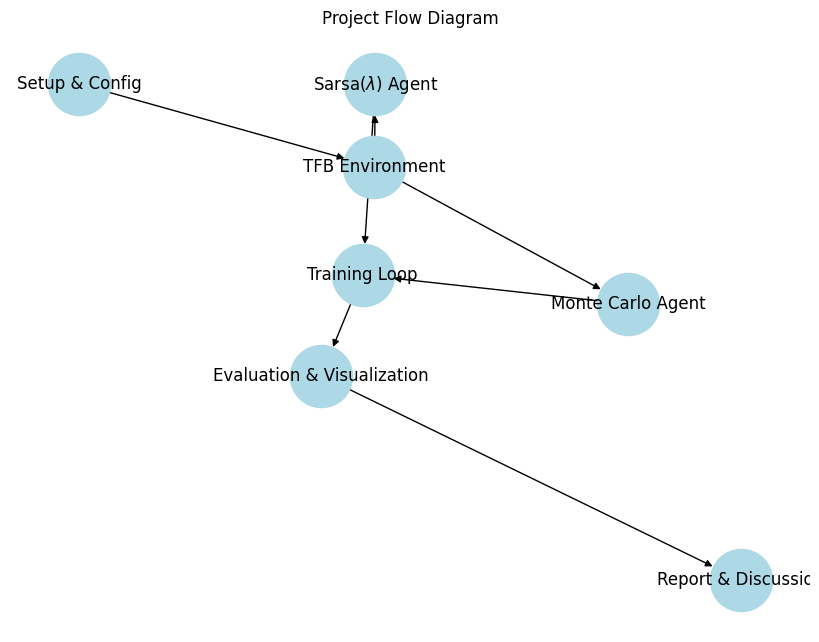

In [7]:
# Step 1.1: Environment and Reproducibility Setup
import numpy as np
import random
import matplotlib.pyplot as plt
import os, sys
import gymnasium as gym
import time
from collections import defaultdict
from tqdm import tqdm
from rl_glue import RLGlue

# Set environment parameters
env_config = {
    'height': 15,
    'width': 20,
    'pipe_gap': 4
}

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("Environment configuration:", env_config)
print("Random seeds set for reproducibility.")

# Step 1.2: Visual Project Flow Diagram
import networkx as nx

# Define the high-level components of the project
G = nx.DiGraph()
G.add_edges_from([
    ("Setup & Config", "TFB Environment"),
    ("TFB Environment", "Monte Carlo Agent"),
    ("TFB Environment", "Sarsa($\lambda$) Agent"),
    ("Monte Carlo Agent", "Training Loop"),
    ("Sarsa($\lambda$) Agent", "Training Loop"),
    ("Training Loop", "Evaluation & Visualization"),
    ("Evaluation & Visualization", "Report & Discussion")
])

pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrows=True)
plt.title("Project Flow Diagram")
plt.show()


In [8]:
# Step 2: Initialize the TFB Environment
from gymnasium.envs.registration import register

register(
    id='TextFlappyBird-v0',
    entry_point='text_flappy_bird_gym.envs:TextFlappyBirdEnvSimple'
) ## can be deleted, forces the access to the environment if the environment 
# if necessary

env = gym.make('TextFlappyBird-v0', **env_config)
print("Environment initialized and rendered successfully.")

Environment initialized and rendered successfully.


In [9]:
## step 2.1: get some general observation on the env
# Print basic information about the environment.
print("Environment Observation Space:", env.observation_space)
print("Environment Action Space:", env.action_space)

# Reset the environment to get the initial state.
initial_state = env.reset()
print("\nInitial observation type:", type(initial_state))
print("Initial observation content:")

# If the observation is a dictionary, print its keys and the dictionary.
if isinstance(initial_state, dict):
    print("Observation keys:", list(initial_state.keys()))
    for key, value in initial_state.items():
        print(f"{key}: {value}")
# If it's a numpy array or another type, print directly.
else:
    print(initial_state)

Environment Observation Space: Tuple(Discrete(14), Discrete(22, start=-11))
Environment Action Space: Discrete(2)

Initial observation type: <class 'tuple'>
Initial observation content:
((13, 3), {'score': 0, 'player': [6, 7], 'distance': np.float64(13.341664064126334)})


In [10]:
obs = env.reset()
## we first play randomly
# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()


Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=3)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=2)
Text Flappy Bird!
Score: 0
----------------------
[       

In [11]:
## monte carlo agent: we shall use TP4 with alpha mc control

# [Graded]
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()[0]
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done, _, info = env.step(action) 
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] += 1 - epsilon 
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha * (np.dot(discounts[:len
    (rewards)-i], rewards[i:]) - old_Q)
    return Q

In [12]:
# [Graded]
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env,Q,epsilon,nA) #-- call the 
        # appropriate 
        # function
        # update the action-value function estimate using the episode
        Q = update_Q(env,episode,Q,alpha,gamma) #-- call the appropriate 
        # function
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [13]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 50000, 0.02)

Episode 50000/50000.

In [14]:
# obtain the corresponding state-value function and plot
V = dict((k,np.max(v)) for k, v in Q.items())

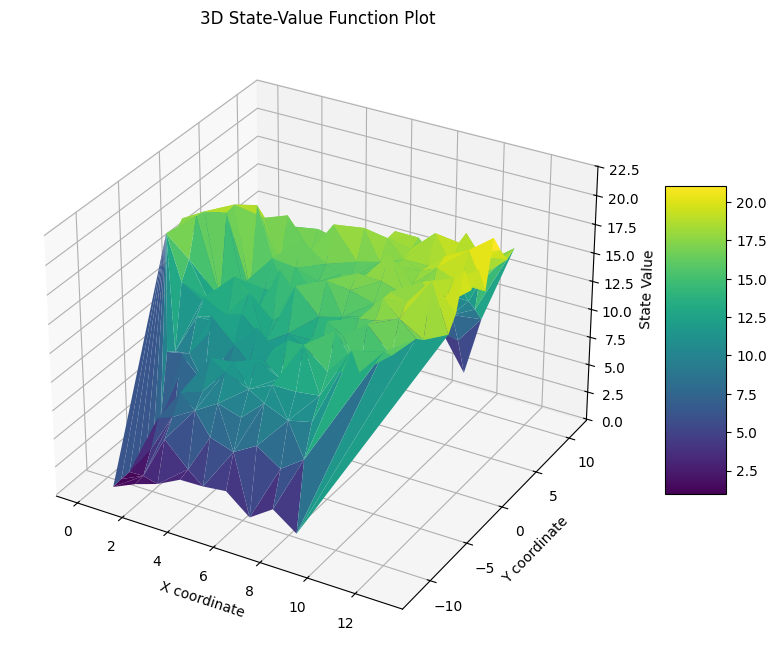

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection


# Convert dictionary keys and values into arrays
keys = np.array(list(V.keys()))
values = np.array(list(V.values()))

# Extract x and y coordinates from keys
X = keys[:, 0]
Y = keys[:, 1]
Z = values

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use plot_trisurf to plot the 3D surface for irregularly spaced data
surf = ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none')

ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_zlabel('State Value')
ax.set_title('3D State-Value Function Plot')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # add a color bar

plt.show()

In [16]:
## we make our agent play !!! 
obs = env.reset()[0]
# iterate
i=0
while True:

    # Select next action
    action = policy[obs] # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS
    i+=1
    # If player is dead break
    if done or i==100:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=2)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=1)
Text Flappy Bird!
Score: 0
----------------------
[       

In [17]:
## we now implement sarsa
import agent
class SarsaLambdaAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """
        Setup for the agent called when the experiment first starts.
        Args:
            agent_init_info (dict): parameters used to initialize the agent:
                {
                    num_states (int): number of states,
                    num_actions (int): number of actions,
                    epsilon (float): epsilon for exploration,
                    step_size (float): step-size,
                    discount (float): discount factor,
                    lambda (float): lambda for eligibility traces,
                    seed (int): random seed,
                }
        """
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.lambda_ = agent_init_info.get("lambda", 0.9)
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create a Q-value table and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions))
        # Create an eligibility trace table.
        self.e = np.zeros((self.num_states, self.num_actions))
        
    def agent_start(self, state):
        """
        The first method called when the episode starts.
        Args:
            state (int): starting state.
        Returns:
            action (int): first action.
        """
        # Reset eligibility traces at the start of the episode.
        self.e = np.zeros((self.num_states, self.num_actions))
        
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """
        A step taken by the agent.
        Args:
            reward (float): reward received for the last action,
            state (int): new state after the step.
        Returns:
            action (int): next action.
        """
        # Choose the next action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Compute the TD error:
        td_error = reward + self.discount * self.q[state, action] - self.q[self.prev_state, self.prev_action]
        
        # Update eligibility trace for the previous state-action pair:
        self.e[self.prev_state, self.prev_action] += 1
        
        # Update all Q-values using the eligibility traces:
        self.q += self.step_size * td_error * self.e
        
        # Decay the eligibility traces:
        self.e *= self.discount * self.lambda_
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """
        Called when the episode terminates.
        Args:
            reward (float): reward received at the terminal state.
        """
        # Compute the TD error at termination:
        td_error = reward - self.q[self.prev_state, self.prev_action]
        
        # Update eligibility trace for the last state-action pair:
        self.e[self.prev_state, self.prev_action] += 1
        
        # Update Q-values using the final TD error:
        self.q += self.step_size * td_error * self.e
        
        # Reset eligibility traces (optional at the end of the episode).
        self.e = np.zeros((self.num_states, self.num_actions))
    
    def argmax(self, q_values):
        # Compute the maximum value
        max_val = np.max(q_values)
        # Get all indices where q_values equals the maximum value
        indices = np.where(q_values == max_val)[0]
        # Choose one index randomly from those indices
        return self.rand_generator.choice(indices)

In [18]:


# Create your environment.
env = gym.make('TextFlappyBird-v0', **env_config)

# Instantiate your agent and initialize it.
agent_instance = SarsaLambdaAgent()
agent_instance.agent_init(agent_info)

num_episodes = 50000
reward_sums = []

# Manual training loop.
for episode in tqdm(range(num_episodes)):
    total_reward = 0
    # Reset the environment. If your env.reset() returns a tuple (obs, info), extract the observation.
    state = env.reset()[0]
    action = agent_instance.agent_start(state)
    done = False

    while not done:
        # Take a step in the environment.
        result = env.step(action)
        # Depending on your gym version, step might return 4 or 5 values.
        if len(result) == 5:
            next_state, reward, done, _, info = result
        else:
            next_state, reward, done, info = result
        
        total_reward += reward
        
        if not done:
            action = agent_instance.agent_step(reward, next_state)
        else:
            agent_instance.agent_end(reward)
        
        state = next_state

    reward_sums.append(total_reward)

# Plot the reward sum per episode.
plt.plot(reward_sums)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.show()


NameError: name 'agent_info' is not defined